In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import vgg19

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

In [2]:
Path_style = './artistic_style.jpeg'
Path_content = './chicago.jpg'

In [3]:
device = "cpu"

In [44]:
model = models.vgg19(pretrained=True).features

In [67]:
transform = transforms.Compose([
    transforms.Resize(128),  # scale imported image
    transforms.ToTensor()])

to_pil = transforms.ToPILImage()

In [68]:
def load_image(image_name):
    image = Image.open(image_name).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

In [69]:
c = load_image(Path_content)
s = load_image(Path_style)

In [101]:
c.size()

torch.Size([1, 3, 256, 256])

In [70]:
def plot_img(content_img, style_img, title=None):
    content_image = to_pil(content_img.cpu().clone().squeeze())
    
    style_image = to_pil(style_img.cpu().clone().squeeze())
    
    fig = plt.figure(figsize = (20, 10))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(content_image, aspect="auto")
    if title is not None:
        plt.title(title[0], fontsize=30)
    ax.axis('off')
    
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(style_image, aspect="auto")
    if title is not None:
        ax.set_title(title[1], fontsize=30)
    ax.axis('off')

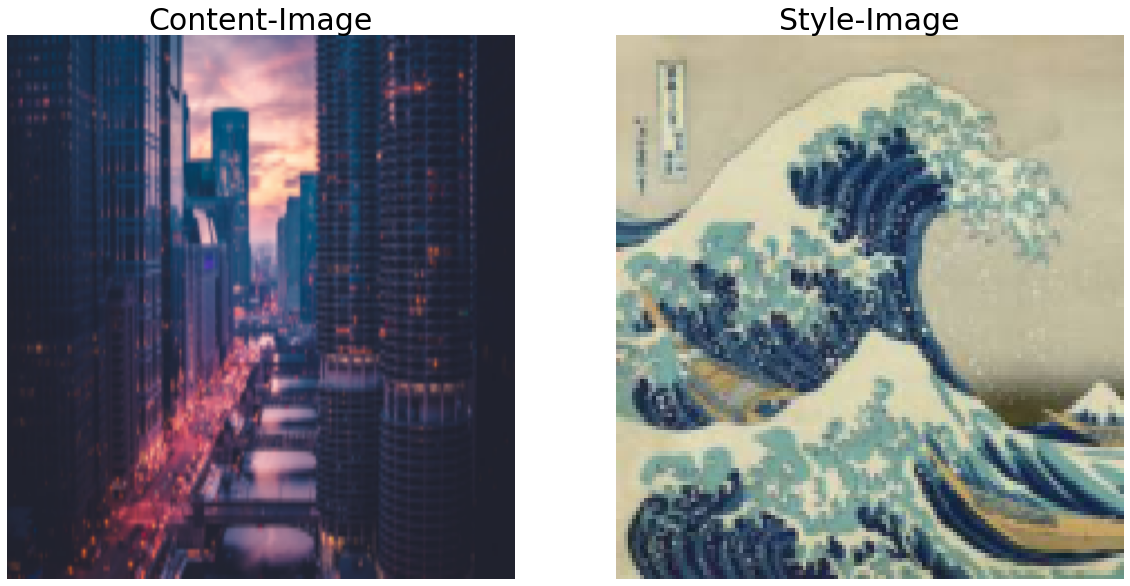

In [71]:
plot_img(c, s, title=['Content-Image', 'Style-Image'])

In [72]:
class VGG19(nn.Module):
    def __init__(self,):
        super(VGG19, self).__init__()
        self.model = vgg19(pretrained=True).features
        self.conv_1_1 = nn.Sequential(*list(self.model.children())[0:1])
        self.conv_2_1 = nn.Sequential(*list(self.model.children())[1:6])
        self.conv_3_1 = nn.Sequential(*list(self.model.children())[6:11])   
        self.conv_4_1 = nn.Sequential(*list(self.model.children())[11:20])
        self.conv_4_2 = nn.Sequential(*list(self.model.children())[11:22])
        self.conv_5_1 = nn.Sequential(*list(self.model.children())[20:29])

    
    def forward(self, x):
        out_1_1 = self.conv_1_1(x)
        out_2_1 = self.conv_2_1(out_1_1)
        out_3_1 = self.conv_3_1(out_2_1)
        out_4_1 = self.conv_4_1(out_3_1)
        out_4_2 = self.conv_4_2(out_3_1)
        out_5_1 = self.conv_5_1(out_4_1)
#         vgg_outputs = namedtuple("VggOutputs", ["conv_1_1", "conv_2_1", "conv_3_1", "conv_4_1", "conv_5_1", "conv_4_2"])
        return [out_1_1, out_2_1, out_3_1, out_4_1, out_5_1, out_4_2]
        

In [73]:
model = VGG19().to(device)

In [74]:
style_features = model(s)[:-1]

In [75]:
def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())
    
    return gram_mat

In [76]:
style_grams = [gram_matrix(y) for y in style_features]

In [77]:
content_features = model(c)[-1]

In [78]:
print_after = 50
epochs = 100
optimizer = torch.optim.Adam([target_image.requires_grad_()],lr=0.007)

In [79]:
target_image = c.clone().requires_grad_(True).to(device)

In [80]:
style_coeff = 1e10
content_coeff = 1e5
style_layers = ["conv_1_1", "conv_2_1", "conv_3_1", "conv_4_1", "conv_5_1"]
l2_loss = torch.nn.MSELoss().to(device)

In [81]:
# with torch.autograd.set_detect_anomaly(True):
for i in range(2):
    optimizer.zero_grad()
    target_features = model(target_image)
    target_features_style = model(target_image)[:-1]

    # Compute content loss as MSE between features
    content_loss = l2_loss(content_features,target_features[-1].detach())

    # Compute style loss as MSE between gram matrices
    style_loss = 0
#     for t_y, gm_s in zip(target_features[:-1], style_grams):
#         gm_y = gram_matrix(t_y)
#         style_loss += l2_loss(gm_y, gm_s[:, :])
    target_grams = [gram_matrix(y) for y in target_features_style]
    for n in range(len(style_grams)):
        style_loss = style_loss + l2_loss(target_grams[n],style_grams[n])
    style_loss = style_loss*style_coeff
    content_loss = content_loss*content_coeff

    total_loss = style_loss + content_loss

    if i%10==0:       
        print("epoch ",i," ", total_loss)

    
    total_loss.backward()
    optimizer.step()

#         if i%print_after == 0:
#             plt.imshow(to_pil(target_image.cpu().clone().squeeze()),label="Epoch "+str(i))
#             plt.show()
#             plt.imsave(str(i)+'.jpg',to_pil(target_image.cpu().clone().squeeze()),format='jpg')




epoch  0   tensor(3.1364e+16, grad_fn=<AddBackward0>)


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1, 256, 32, 56]], which is output 0 of ReluBackward1, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [44]:
content_features

tensor([[[[-3.7395e+00, -7.6192e+00, -7.9774e+00,  ..., -6.9253e+00,
           -8.5996e+00, -6.1210e+00],
          [-9.8993e+00, -1.1433e+01, -1.2897e+01,  ..., -7.8849e+00,
           -1.0427e+01, -8.9282e+00],
          [-1.1027e+01, -1.0859e+01, -1.0173e+01,  ..., -8.4733e+00,
           -9.2135e+00, -7.7040e+00],
          ...,
          [-6.7769e+00, -8.3739e+00, -7.6116e+00,  ..., -3.5016e+00,
           -2.9473e+00, -2.9839e+00],
          [-9.9312e+00, -1.5729e+01, -1.4440e+01,  ..., -6.3321e+00,
           -5.3655e+00, -4.2281e+00],
          [-2.3466e+00, -9.3989e+00, -9.4459e+00,  ..., -1.8779e+00,
           -1.7547e+00, -3.8395e-01]],

         [[-3.0769e+00, -5.1170e+00, -4.3064e+00,  ..., -5.9298e+00,
           -3.7051e+00, -1.4611e+00],
          [-3.8584e+00, -6.5244e+00, -6.5008e+00,  ..., -9.6235e+00,
           -5.8310e+00, -1.4533e+00],
          [-3.3955e+00, -4.8463e+00, -4.2455e+00,  ..., -6.2868e+00,
           -3.9581e+00,  3.2670e-01],
          ...,
     

In [42]:
target_features[-1]

tensor([[[[-3.7395e+00, -7.6192e+00, -7.9774e+00,  ..., -6.9253e+00,
           -8.5996e+00, -6.1210e+00],
          [-9.8993e+00, -1.1433e+01, -1.2897e+01,  ..., -7.8849e+00,
           -1.0427e+01, -8.9282e+00],
          [-1.1027e+01, -1.0859e+01, -1.0173e+01,  ..., -8.4733e+00,
           -9.2135e+00, -7.7040e+00],
          ...,
          [-6.7769e+00, -8.3739e+00, -7.6116e+00,  ..., -3.5016e+00,
           -2.9473e+00, -2.9839e+00],
          [-9.9312e+00, -1.5729e+01, -1.4440e+01,  ..., -6.3321e+00,
           -5.3655e+00, -4.2281e+00],
          [-2.3466e+00, -9.3989e+00, -9.4459e+00,  ..., -1.8779e+00,
           -1.7547e+00, -3.8395e-01]],

         [[-3.0769e+00, -5.1170e+00, -4.3064e+00,  ..., -5.9298e+00,
           -3.7051e+00, -1.4611e+00],
          [-3.8584e+00, -6.5244e+00, -6.5008e+00,  ..., -9.6235e+00,
           -5.8310e+00, -1.4533e+00],
          [-3.3955e+00, -4.8463e+00, -4.2455e+00,  ..., -6.2868e+00,
           -3.9581e+00,  3.2670e-01],
          ...,
     

In [82]:
model.model[0:4]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
)